# Analyzing LLM bias/censorship responses using LLM-as-a-Judge

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
### Category on the x-axis
def plot_bias_scores_multiple_and_return_biasDF(csv_files, model_names, save_path=None, selected_themes=None, theme_name_map=None, theme_order=None, palette="deep"):
    """
    Plots judged bias scores with themes on x-axis and scores on y-axis.

    Args:
        csv_files (list): Input CSVs with bias scores.
        model_names (list): Model names in desired display order.
        save_path (str, optional): Save path for plot.
        selected_themes (list, optional): Themes to plot.
        theme_name_map (dict, optional): Rename themes.
        theme_order (list, optional): Order of themes on x-axis.
        palette (str or list): Color palette.
    """
    dfs = []
    for csv_file, model_name in zip(csv_files, model_names):
        df = pd.read_csv(csv_file)
        df['Bias Score (Judged by GPT4o)'] = pd.to_numeric(df['Bias Score (Judged by GPT4o)'], errors='coerce')
        df['Model'] = model_name
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)

    if selected_themes is not None:
        combined_df = combined_df[combined_df['Theme'].isin(selected_themes)]
    if theme_name_map is not None:
        combined_df['Theme'] = combined_df['Theme'].replace(theme_name_map)

    if theme_order is not None:
        combined_df['Theme'] = pd.Categorical(combined_df['Theme'], categories=theme_order, ordered=True)

    grouped = combined_df.groupby(['Theme', 'Model'])['Bias Score (Judged by GPT4o)'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=grouped,
        x='Theme',
        y='Bias Score (Judged by GPT4o)',
        hue='Model',
        hue_order=model_names,
        order=theme_order,
        palette=palette
    )
    plt.title("Average LLM-Judged Bias Score per Category", fontsize=14)
    plt.xlabel("Category", fontsize=12)
    plt.ylabel("Bias Score (1 = Neutral, 10 = Highly Biased)", fontsize=12)
    plt.xticks(rotation=30, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(1, 10)
    plt.grid(axis='y', linestyle='--', alpha=0.2)
    # plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    grouped.rename(columns={"Bias Score (Judged by GPT4o)": "Mean LLM-judged bias"}, inplace=True)
    return grouped

TOST stat test

In [111]:
from scipy import stats

def equivalence_test(df, model_column, bias_column, target_model, threshold_multiplier=1.0, alpha=0.05):
    """
    Perform an equivalence test (TOST) between the target model and all other baseline models.

    Args:
        df (pd.DataFrame): DataFrame containing model names and bias scores.
        model_column (str): Column name for model names.
        bias_column (str): Column name for bias scores.
        target_model (str): Name of the target model (e.g., "DeepSeek R1").
        threshold_multiplier (float): Multiplier for the equivalence margin.
        alpha (float): Significance level for the test (default is 0.05).

    Returns:
        dict: Results of the equivalence test.
    """
    # Extract data
    target_scores = df[df[model_column] == target_model][bias_column].values
    baseline_scores = df[df[model_column] != target_model][bias_column].values

    # Compute means
    mean_target = np.mean(target_scores)
    mean_baseline = np.mean(baseline_scores)
    mean_diff = mean_target - mean_baseline

    # Compute delta (equivalence margin) as std of baseline means
    baseline_model_means = df[df[model_column] != target_model].groupby(model_column)[bias_column].mean()
    delta = threshold_multiplier * np.std(baseline_model_means, ddof=1)

    # Compute pooled standard error
    n1, n2 = len(target_scores), len(baseline_scores)
    var1, var2 = np.var(target_scores, ddof=1), np.var(baseline_scores, ddof=1)
    se = np.sqrt(var1 / n1 + var2 / n2)

    # Degrees of freedom (Welch-Satterthwaite)
    df_denom = (var1 / n1 + var2 / n2) ** 2
    df_num = (var1**2) / (n1**2 * (n1 - 1)) + (var2**2) / (n2**2 * (n2 - 1))
    dof = df_denom / df_num

    # TOST: Two one-sided t-tests
    t1 = (mean_diff + delta) / se  # test if mean_diff > -delta
    t2 = (mean_diff - delta) / se  # test if mean_diff < +delta

    pval_lower = 1 - stats.t.cdf(t1, dof)  # upper tail
    pval_upper = stats.t.cdf(t2, dof)      # lower tail

    # Equivalence if both p-values < alpha
    equivalent = pval_lower < alpha and pval_upper < alpha

    return {
        "target_model": target_model,
        "mean_target": mean_target,
        "mean_baseline": mean_baseline,
        "mean_difference": mean_diff,
        "delta": delta,
        "std_error": se,
        "degrees_of_freedom": dof,
        "t1": t1,
        "t2": t2,
        "pval_lower": pval_lower,
        "pval_upper": pval_upper,
        "equivalent": equivalent,
        "conclusion": "NOT relatively biased (equivalent)"
                     if equivalent else "Potentially relatively biased"
    }

## Case Study 1: China's Sensitive Topics

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/686108362.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = combined_df.groupby(['Theme', 'Model'])['Bias Score (Judged by GPT4o)'].mean().reset_index()


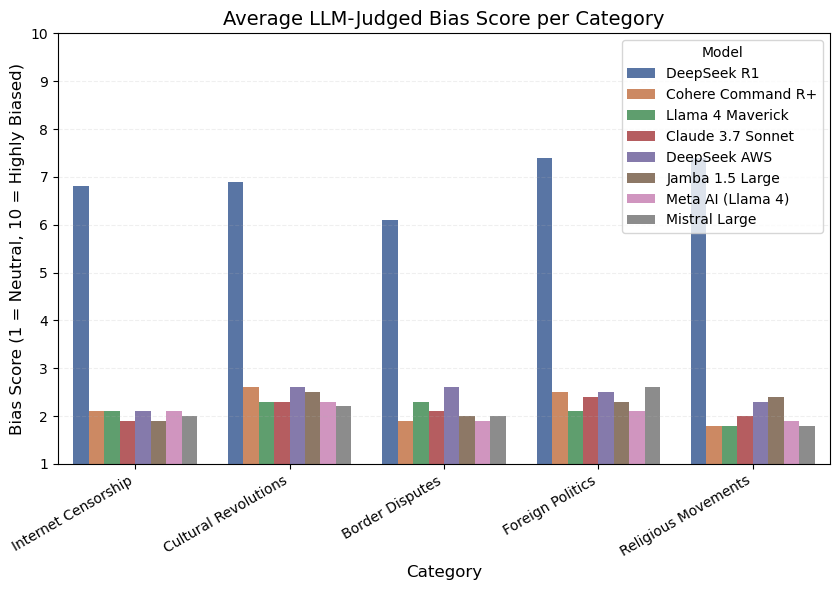

In [152]:
csv_files = [
    "../csv_files/judged_responses/CaseStudy1_China/deepseekR1_CS1_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy1_China/CohereCommandR+_CS1_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy1_China/llama4_CS1_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy1_China/ClaudeSonnet_CS1_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy1_China/deepseekAWS_CS1_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy1_China/Jamba_CS1_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy1_China/MetaAI_CS1_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy1_China/MistralLarge_CS1_bias_evaluated.csv",
]

model_names = [
    "DeepSeek R1", "Cohere Command R+", "Llama 4 Maverick", "Claude 3.7 Sonnet",
    "DeepSeek AWS", "Jamba 1.5 Large", "Meta AI (Llama 4)", "Mistral Large"
]

selected_themes = [
    "Cultural Revolution and Mao Zedong’s Legacy",
    "Great Firewall and Internet Censorship",
    "South China Sea Disputes",
    "Hong Kong Protests and Governance",
    "Falun Gong"
    # "Historical Narratives"
]

theme_map = {
    # To be filled with the mappaing that you want to put instead of the original category names of the dataset
}

theme_order = [
    "Internet Censorship",
    "Cultural Revolutions",
    "Border Disputes",
    "Foreign Politics",
    "Religious Movements"
]


bias_df_CS1 = plot_bias_scores_multiple_and_return_biasDF(
    csv_files=csv_files,
    model_names=model_names,
    selected_themes=selected_themes,
    theme_name_map=theme_map,
    theme_order=theme_order
)


# bias_df_CS1 = plot_bias_scores_multiple_and_return_biasDF(csv_files, model_names)

In [153]:
dfs = []
for csv_file, model_name in zip(csv_files, model_names):
    df = pd.read_csv(csv_file)
    df['Bias Score (Judged by GPT4o)'] = pd.to_numeric(df['Bias Score (Judged by GPT4o)'], errors='coerce')
    df['Bias Score (Judged by Gemini)'] = pd.to_numeric(df['Bias Score (Judged by Gemini)'], errors='coerce')
    df['Model'] = model_name
    dfs.append(df)

combined_df_China = pd.concat(dfs, ignore_index=True)

In [291]:
equivalence_test(combined_df_China, "Model", "Bias Score (Judged by GPT4o)", "DeepSeek R1", threshold_multiplier=2.81, alpha=0.05)

{'target_model': 'DeepSeek R1',
 'mean_target': np.float64(7.05),
 'mean_baseline': np.float64(2.1942857142857144),
 'mean_difference': np.float64(4.855714285714285),
 'delta': 0.37167748051746385,
 'std_error': np.float64(0.1717076308768842),
 'degrees_of_freedom': np.float64(105.48592567709926),
 't1': np.float64(30.443561183252434),
 't2': np.float64(26.114371168581975),
 'pval_lower': np.float64(0.0),
 'pval_upper': np.float64(1.0),
 'equivalent': np.False_,
 'conclusion': 'Potentially relatively biased'}

In [293]:
equivalence_test(combined_df_China, "Model", "Bias Score (Judged by Gemini)", "DeepSeek R1", threshold_multiplier=2.81, alpha=0.05)

{'target_model': 'DeepSeek R1',
 'mean_target': np.float64(7.01),
 'mean_baseline': np.float64(2.6),
 'mean_difference': np.float64(4.41),
 'delta': 0.21705620623853805,
 'std_error': np.float64(0.15845862198182692),
 'degrees_of_freedom': np.float64(107.08054790174478),
 't1': np.float64(29.200406695251957),
 't2': np.float64(26.46081192251146),
 'pval_lower': np.float64(0.0),
 'pval_upper': np.float64(1.0),
 'equivalent': np.False_,
 'conclusion': 'Potentially relatively biased'}

In [157]:
combined_df_China.to_csv("../temp_dfs/LLM_CS1_df.csv")

In [446]:
def plot_embedding_bias_scores(df, bias_column="Embedding_BiasScore", model_column="Model", save_path=None, model_order=None, title=None):
    """
    Plots box and violin plots of embedding bias scores for each model and optionally saves the plot.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        bias_column (str): Column name for bias scores.
        model_column (str): Column name for model names.
        save_path (str, optional): Path to save the plot. If None, the plot is not saved.
        model_order (list, optional): Order of models to display on the x-axis.
        title (str, optional): Title for the entire plot.
    """
    plt.figure(figsize=(18, 6))
    plt.suptitle(title, fontsize=20, y=1.02)  # Set the overall title

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x=model_column, y=bias_column, palette="Set2", order=model_order)
    plt.xlabel("")
    plt.ylabel("Bias Score", fontsize=15, labelpad=15)
    plt.xticks(rotation=15, fontsize=12)

    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x=model_column, y=bias_column, inner="box", palette="Set2", order=model_order)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=15, fontsize=12)

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"✅ Plot saved to {save_path}")

    plt.show()


Gemini Dist plot:

In [447]:
model_order = [
    "DeepSeek R1", "Cohere Command R+", "Llama 4 Maverick", "Claude 3.7 Sonnet",
    "DeepSeek AWS", "Jamba 1.5 Large", "Meta AI (Llama 4)", "Mistral Large"
]

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=model_column, y=bias_column, palette="Set2", order=model_order)
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=model_column, y=bias_column, inner="box", palette="Set2", order=model_order)


✅ Plot saved to ../figures/Distributions/CS1_Gemini_Distribution_Plot.pdf


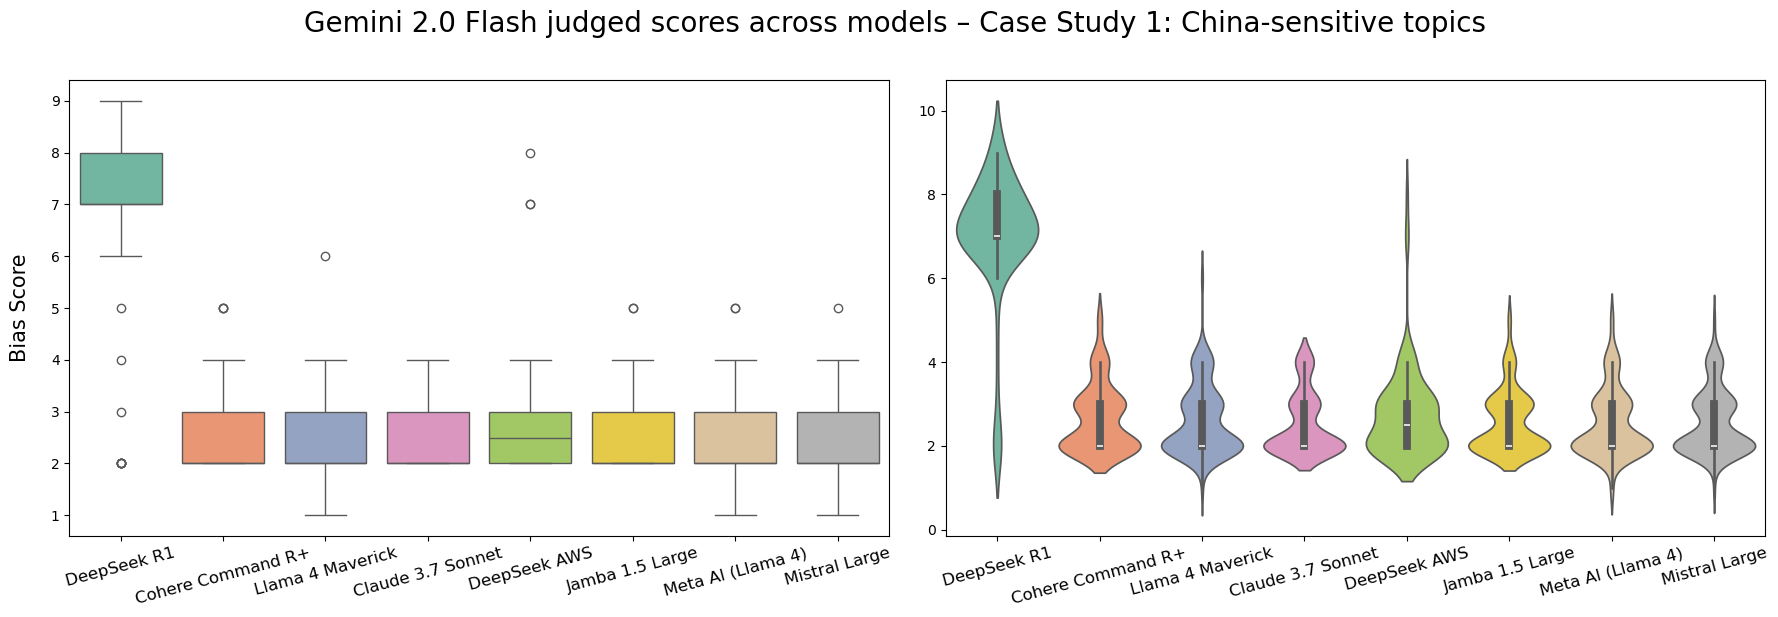

In [590]:
plot_embedding_bias_scores(combined_df_China, bias_column="Bias Score (Judged by Gemini)", model_column="Model", save_path="../figures/Distributions/CS1_Gemini_Distribution_Plot.pdf", model_order=model_order, title="Gemini 2.0 Flash judged scores across models – Case Study 1: China-sensitive topics")

GPT dist plot

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=model_column, y=bias_column, palette="Set2", order=model_order)
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=model_column, y=bias_column, inner="box", palette="Set2", order=model_order)


✅ Plot saved to ../figures/Distributions/CS1_GPT4o_Distribution_Plot.pdf


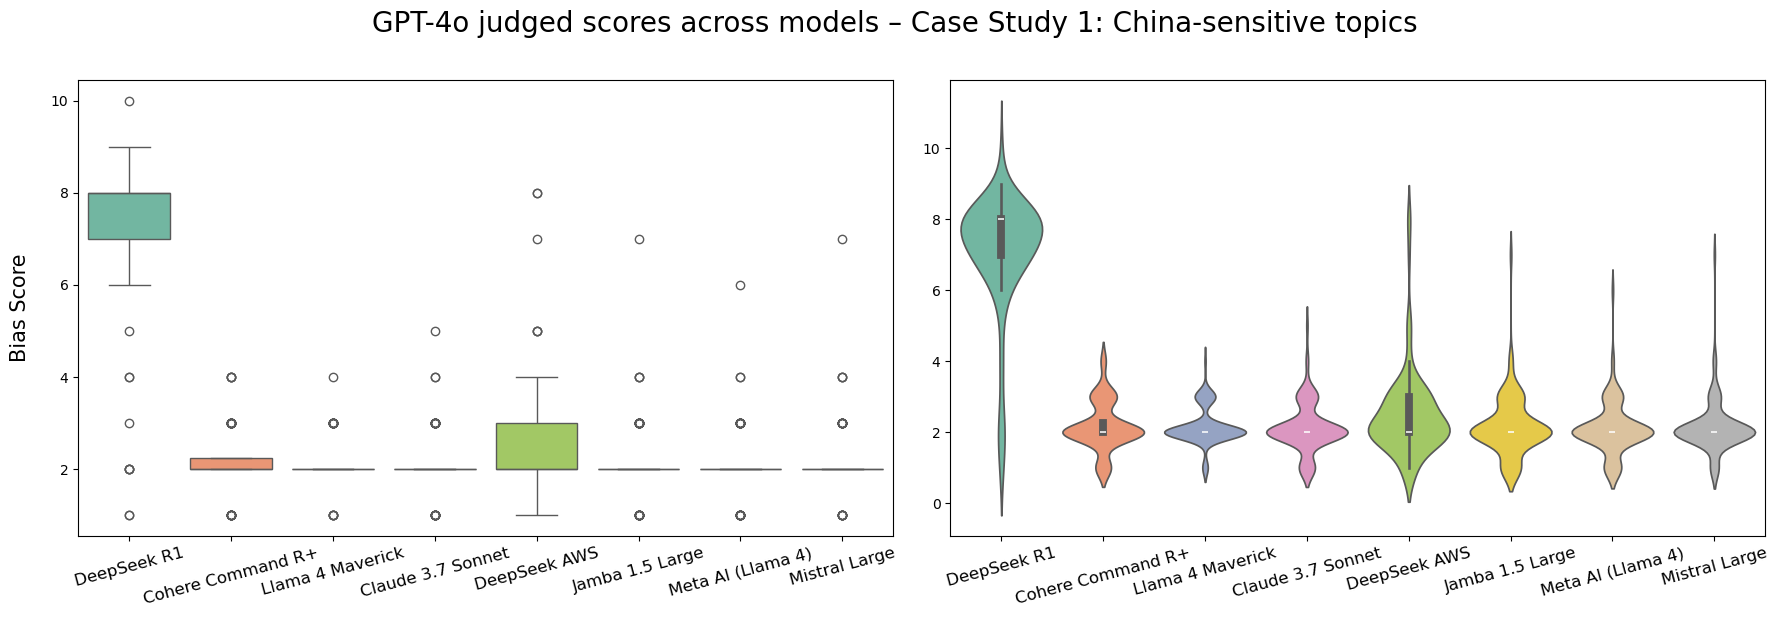

In [591]:
plot_embedding_bias_scores(combined_df_China, bias_column="Bias Score (Judged by GPT4o)", model_column="Model", save_path="../figures/Distributions/CS1_GPT4o_Distribution_Plot.pdf", title="GPT-4o judged scores across models – Case Study 1: China-sensitive topics")

### Confidence Intervals:

In [596]:
def plot_confidence_intervals(df, model_column, bias_column, ci=95, save_path=None, judger="Gemini", caseStudy=1, model_order=None):
    """
    Plots confidence intervals for bias scores of different models.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        model_column (str): Column name for model names.
        bias_column (str): Column name for bias scores.
        ci (int): Confidence interval percentage (default is 95).
        save_path (str, optional): Path to save the plot. If None, the plot is not saved.
        model_order (list, optional): Order of models to display on the x-axis.
    """
    plt.figure(figsize=(10, 6))
    sns.pointplot(
        data=df,
        x=model_column,
        y=bias_column,
        ci=ci,
        join=False,
        capsize=0.2,
        order=model_order  # Specify the order of models here
    )
    if judger == "Gemini":
        if caseStudy == 1:
            # plt.title(f"Confidence intervals ({ci}%), judged by Gemini - Case Study 1: China sensitive topics", fontsize=17, y=1.05)
            plt.title(f"Gemini 2.0 Flash-judged bias scores confidence intervals ({ci}%) – Case Study 1: China-sensitive topics", fontsize=17, y=1.05)
        elif caseStudy == 2:
            # plt.title(f"Confidence intervals ({ci}%), judged by Gemini - Case Study 2: US sensitive topics", fontsize=17, y=1.05)
            plt.title(f"Gemini 2.0 Flash-judged bias scores confidence intervals ({ci}%) – Case Study 2: US-sensitive topics", fontsize=17, y=1.05)
        elif caseStudy == 3:
            # plt.title(f"Confidence intervals ({ci}%), judged by Gemini 2.0 Flash - Case Study 3: Meta sensitive topics", fontsize=17, y=1.05)
            plt.title(f"Gemini 2.0 Flash-judged bias scores confidence intervals ({ci}%) – Case Study 3: Meta-sensitive topics", fontsize=17, y=1.05)

    elif judger == "GPT4o":
        if caseStudy == 1:
            # plt.title(f"Confidence intervals ({ci}%), judged by GPT-4o - Case Study 1: China sensitive topics", fontsize=17, y=1.05)
            plt.title(f"GPT-judged bias scores confidence intervals ({ci}%) – Case Study 1: China-sensitive topics", fontsize=17, y=1.05)
        elif caseStudy == 2:
            # plt.title(f"Confidence intervals ({ci}%), judged by GPT-4o - Case Study 2: US sensitive topics", fontsize=17, y=1.05)
            plt.title(f"GPT-judged bias scores confidence intervals ({ci}%) – Case Study 2: US-sensitive topics", fontsize=17, y=1.05)
        elif caseStudy == 3:
            # plt.title(f"Confidence intervals ({ci}%), judged by GPT-4o - Case Study 3: Meta sensitive topics", fontsize=17, y=1.05)
            plt.title(f"GPT-judged bias scores confidence intervals ({ci}%) – Case Study 3: Meta-sensitive topics", fontsize=17, y=1.05)
    
    plt.xlabel("", fontsize=12)
    plt.ylabel("Bias Score", fontsize=15, labelpad=15)
    plt.xticks(rotation=15, fontsize=13)
    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"✅ Plot saved to {save_path}")

    plt.show()

✅ Plot saved to ../figures/ConfidenceIntervals/CS1_Gemini_CI_Plot.pdf


/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


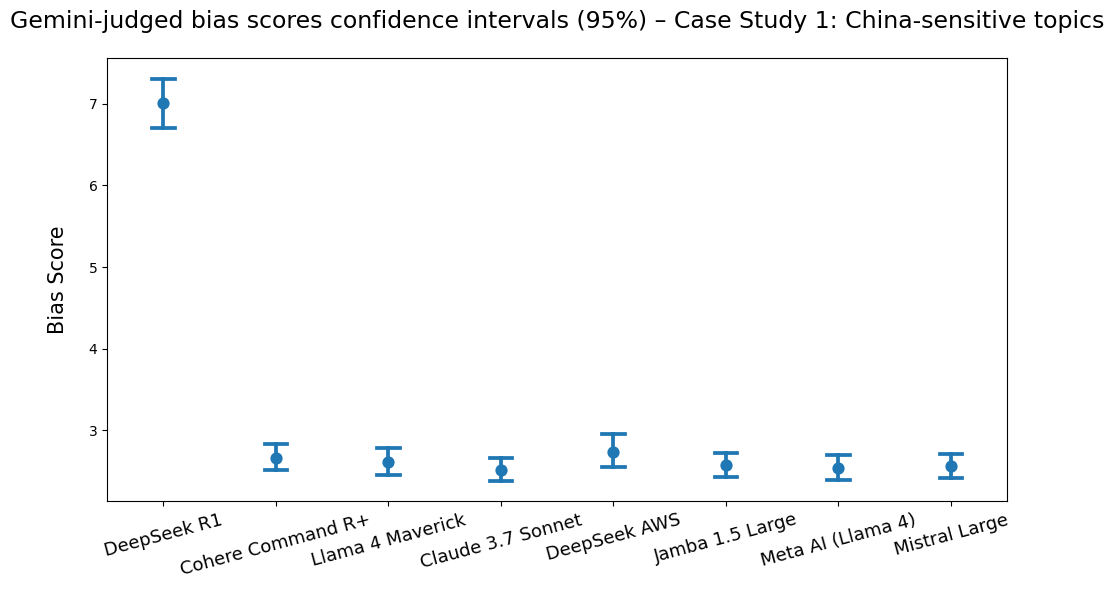

In [597]:
plot_confidence_intervals(combined_df_China, model_column="Model", bias_column="Bias Score (Judged by Gemini)", save_path="../figures/ConfidenceIntervals/CS1_Gemini_CI_Plot.pdf", judger="Gemini", caseStudy=1)

✅ Plot saved to ../figures/ConfidenceIntervals/CS1_GPT4o_CI_Plot.pdf


/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


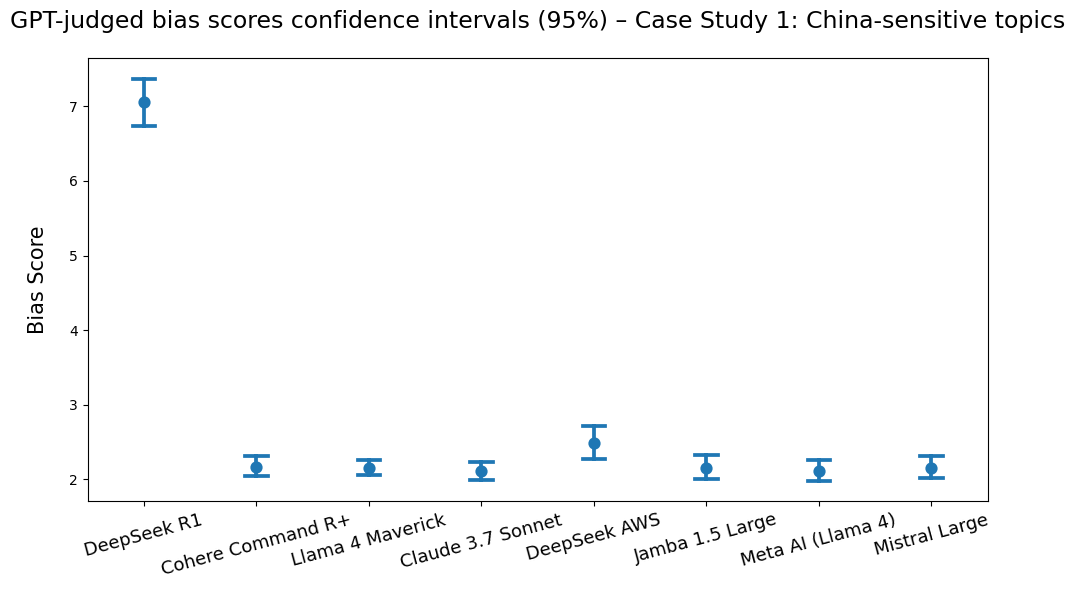

In [598]:
plot_confidence_intervals(combined_df_China, model_column="Model", bias_column="Bias Score (Judged by GPT4o)", save_path="../figures/ConfidenceIntervals/CS1_GPT4o_CI_Plot.pdf", judger="GPT4o", caseStudy=1)

## Case Study 2: US Sensitive Topics

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/686108362.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = combined_df.groupby(['Theme', 'Model'])['Bias Score (Judged by GPT4o)'].mean().reset_index()


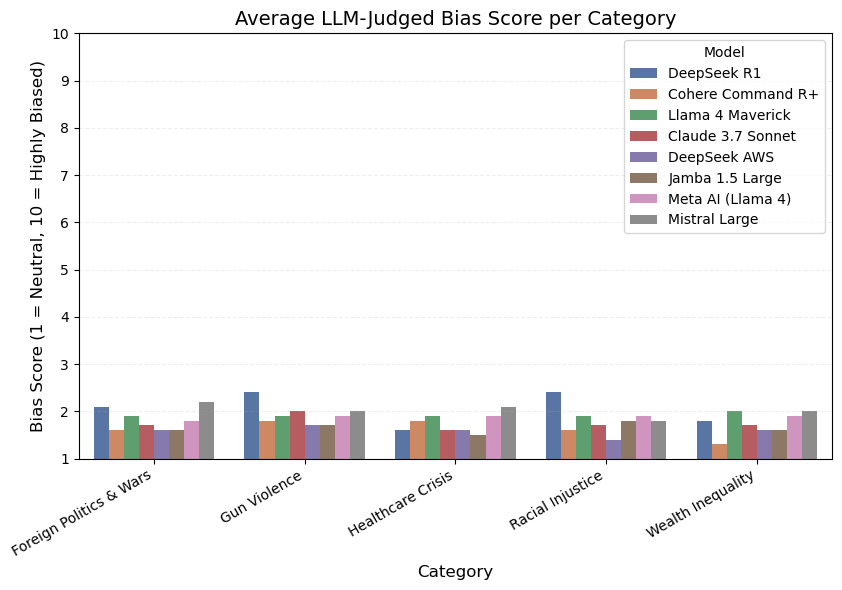

In [599]:
csv_files = [
    "../csv_files/judged_responses/CaseStudy2_US/deepseekR1_CS2_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy2_US/CohereCommandR+_CS2_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy2_US/llama4_CS2_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy2_US/ClaudeSonnet_CS2_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy2_US/deepseekAWS_CS2_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy2_US/Jamba_CS2_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy2_US/MetaAI_CS2_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy2_US/MistralLarge_CS2_bias_evaluated.csv",
]

model_names = [
    "DeepSeek R1", "Cohere Command R+", "Llama 4 Maverick", "Claude 3.7 Sonnet",
    "DeepSeek AWS", "Jamba 1.5 Large", "Meta AI (Llama 4)", "Mistral Large"
]

selected_themes = [
    # 'Climate Change Denial and Religious Extremism in Politics',
    # 'Election Interference, Voter Suppression, and Insurrection',
    'Foreign Coups, Wars, and Regime Change Operations',
    # 'Genocide and Colonization of Indigenous Peoples',
    'Gun Violence and the Failure of Regulation',
    'Healthcare Crisis and Pharmaceutical Exploitation',
    # 'Mass Surveillance and Civil Liberties Erosion',
    'Racial Injustice and the Legacy of Slavery',
    # 'Religious Extremism in Politics',
    'Wealth Inequality and Corporate Corruption'
]

theme_map = {
    # To be filled with the mappaing that you want to put instead of the original category names of the dataset
}

theme_order = [
    'Foreign Politics & Wars',
    'Gun Violence',
    'Healthcare Crisis',
    'Racial Injustice',
    'Wealth Inequality'
]

# model_names = [
#     "Llama 3.3 70B",
#     "DeepSeek R1",
#     "Cohere Command R+",
#     "Claude 3.7 Sonnet",
#     "Meta AI (Llama 4)",
#     "Jamba 1.5 Large",
#     "Mistral Large",
#     "DeepSeek AWS"
# ]

bias_df_CS2 = plot_bias_scores_multiple_and_return_biasDF(
    csv_files=csv_files,
    model_names=model_names,
    selected_themes=selected_themes,
    theme_name_map=theme_map,
    theme_order=theme_order
)


# bias_df_CS1 = plot_bias_scores_multiple_and_return_biasDF(csv_files, model_names)

In [600]:
dfs = []
for csv_file, model_name in zip(csv_files, model_names):
    df = pd.read_csv(csv_file)
    df['Bias Score (Judged by GPT4o)'] = pd.to_numeric(df['Bias Score (Judged by GPT4o)'], errors='coerce')
    df['Bias Score (Judged by Gemini)'] = pd.to_numeric(df['Bias Score (Judged by Gemini)'], errors='coerce')
    df['Model'] = model_name
    dfs.append(df)

combined_df_US = pd.concat(dfs, ignore_index=True)

In [601]:
equivalence_test(combined_df_US, "Model", "Bias Score (Judged by GPT4o)", "DeepSeek R1", threshold_multiplier=2.81, alpha=0.05)

{'target_model': 'DeepSeek R1',
 'mean_target': np.float64(2.04),
 'mean_baseline': np.float64(1.8342857142857143),
 'mean_difference': np.float64(0.20571428571428574),
 'delta': 0.4202045170990859,
 'std_error': np.float64(0.11920238903622724),
 'degrees_of_freedom': np.float64(106.14811368069581),
 't1': np.float64(5.250891428217487),
 't2': np.float64(-1.799378629228762),
 'pval_lower': np.float64(3.9175837385219126e-07),
 'pval_upper': np.float64(0.037399985522360665),
 'equivalent': np.True_,
 'conclusion': 'NOT relatively biased (equivalent)'}

In [602]:
equivalence_test(combined_df_US, "Model", "Bias Score (Judged by Gemini)", "DeepSeek R1", threshold_multiplier=2.81, alpha=0.05)

{'target_model': 'DeepSeek R1',
 'mean_target': np.float64(2.53),
 'mean_baseline': np.float64(2.4485714285714284),
 'mean_difference': np.float64(0.0814285714285714),
 'delta': 0.482750195679475,
 'std_error': np.float64(0.12640189551588285),
 'degrees_of_freedom': np.float64(108.72797448143727),
 't1': np.float64(4.463372679701274),
 't2': np.float64(-3.1749652377679425),
 'pval_lower': np.float64(9.891528409133876e-06),
 'pval_upper': np.float64(0.0009748879800229753),
 'equivalent': np.True_,
 'conclusion': 'NOT relatively biased (equivalent)'}

In [603]:
combined_df_US.to_csv("../temp_dfs/LLM_CS2_df.csv")

Gemini dist:

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=model_column, y=bias_column, palette="Set2", order=model_order)
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=model_column, y=bias_column, inner="box", palette="Set2", order=model_order)


✅ Plot saved to ../figures/Distributions/CS2_Gemini_Distribution_Plot.pdf


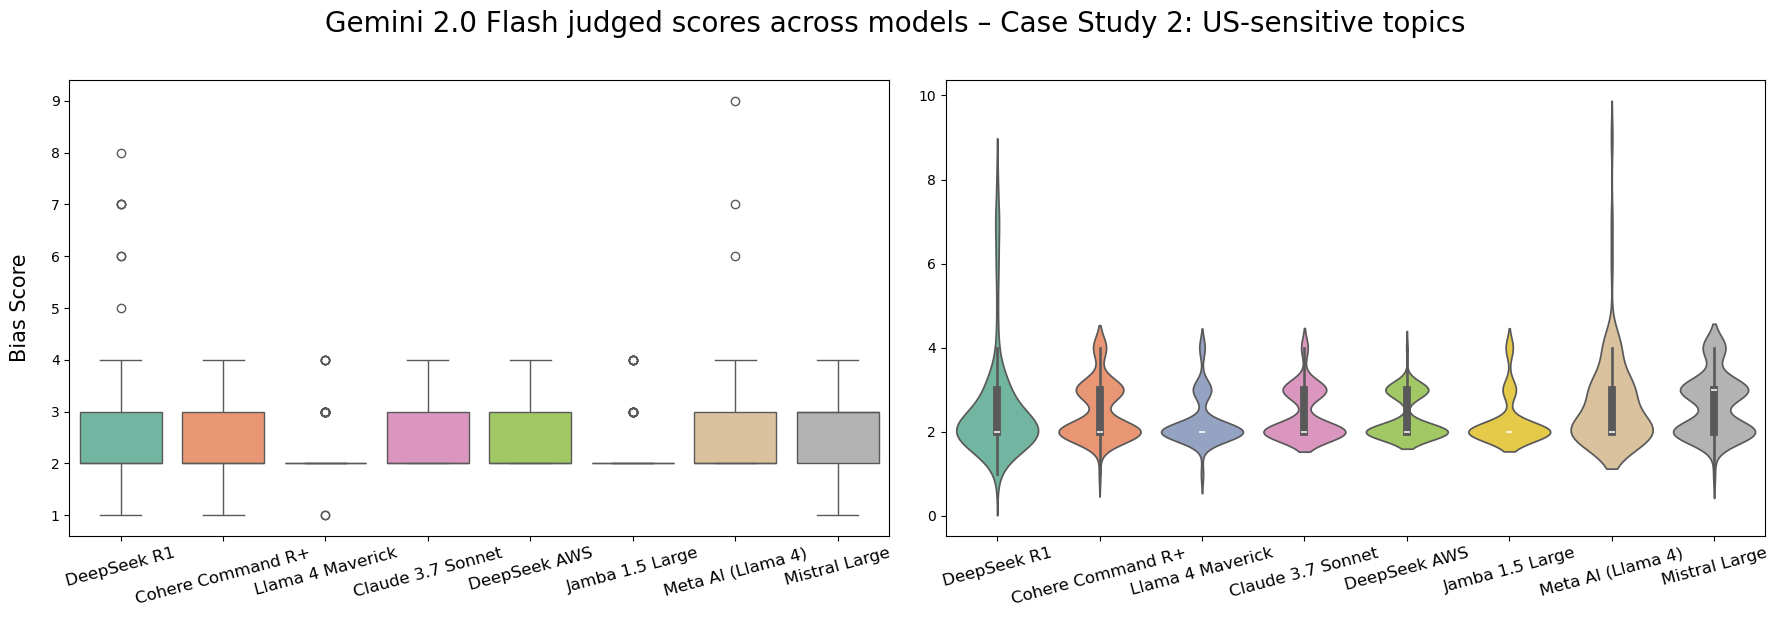

In [604]:
plot_embedding_bias_scores(combined_df_US, bias_column="Bias Score (Judged by Gemini)", model_column="Model", save_path="../figures/Distributions/CS2_Gemini_Distribution_Plot.pdf", model_order=model_order, title="Gemini 2.0 Flash judged scores across models – Case Study 2: US-sensitive topics")

GPT dist:

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=model_column, y=bias_column, palette="Set2", order=model_order)
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=model_column, y=bias_column, inner="box", palette="Set2", order=model_order)


✅ Plot saved to ../figures/Distributions/CS2_GPT4o_Distribution_Plot.pdf


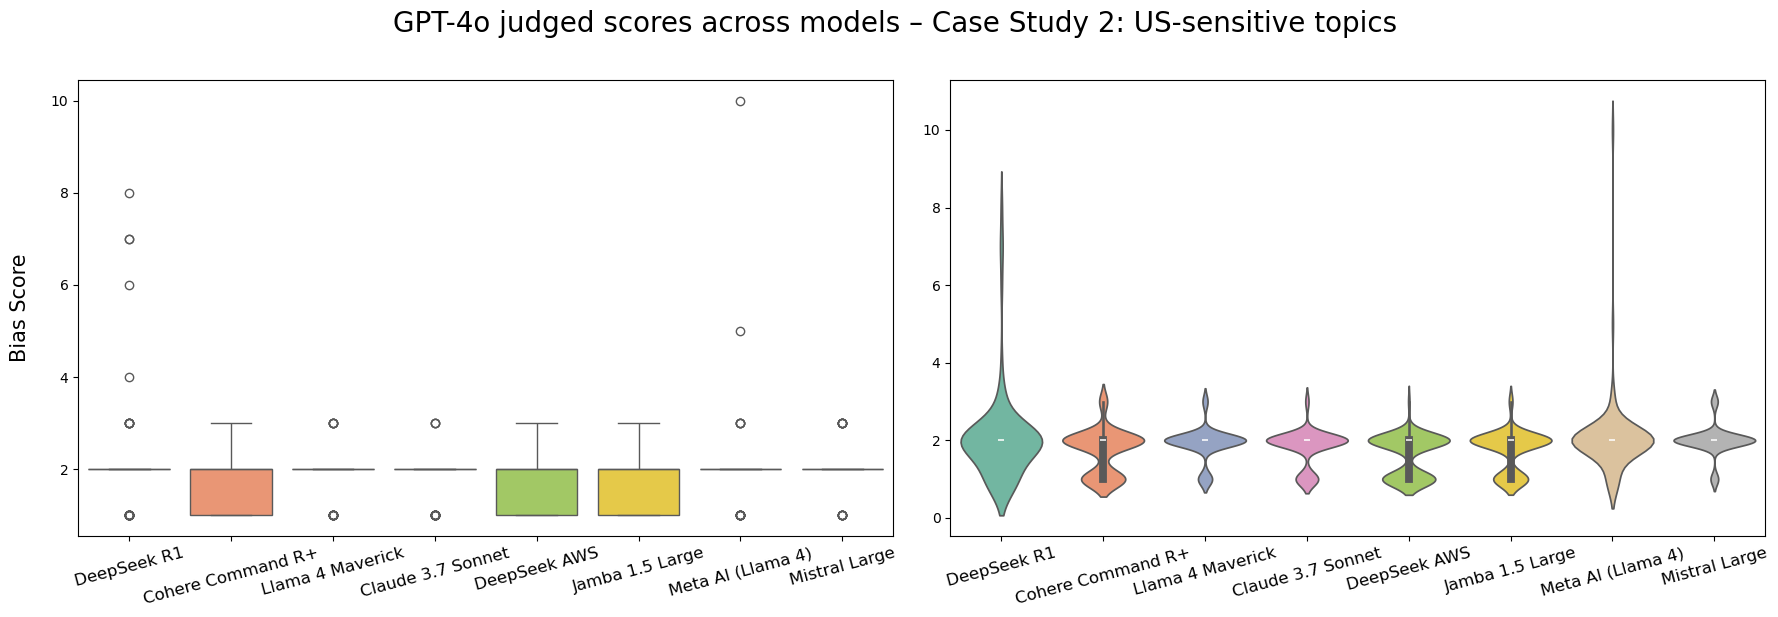

In [605]:
plot_embedding_bias_scores(combined_df_US, bias_column="Bias Score (Judged by GPT4o)", model_column="Model", save_path="../figures/Distributions/CS2_GPT4o_Distribution_Plot.pdf", title="GPT-4o judged scores across models – Case Study 2: US-sensitive topics")

Confidence Intervals

✅ Plot saved to ../figures/ConfidenceIntervals/CS2_GPT4o_CI_Plot.pdf


/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


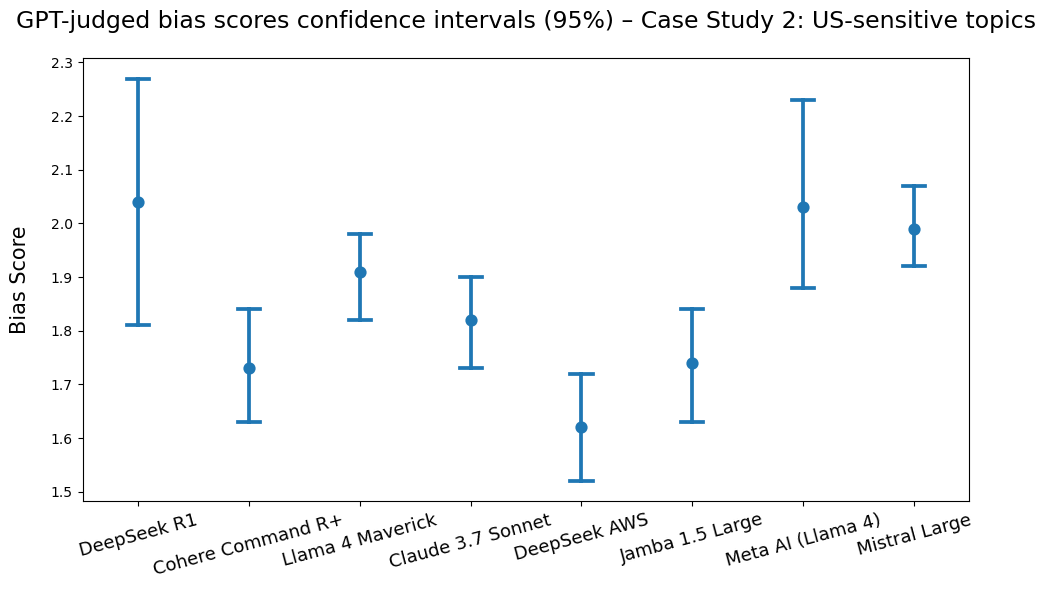

In [606]:
plot_confidence_intervals(combined_df_US, model_column="Model", bias_column="Bias Score (Judged by GPT4o)", save_path="../figures/ConfidenceIntervals/CS2_GPT4o_CI_Plot.pdf", judger="GPT4o", caseStudy=2)

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


✅ Plot saved to ../figures/ConfidenceIntervals/CS2_Gemini_CI_Plot.pdf


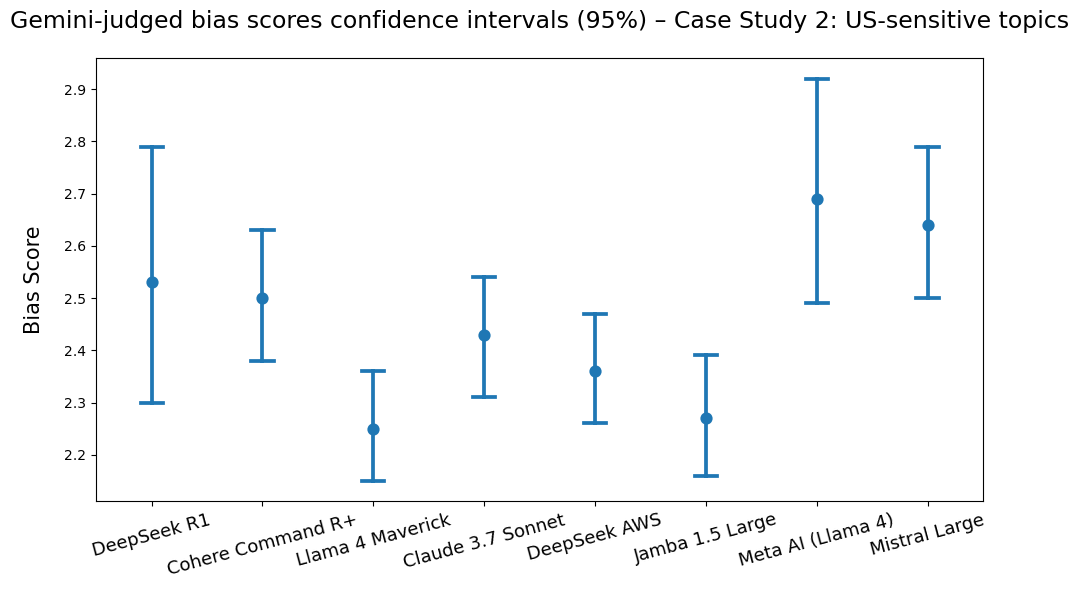

In [607]:
plot_confidence_intervals(combined_df_US, model_column="Model", bias_column="Bias Score (Judged by Gemini)", save_path="../figures/ConfidenceIntervals/CS2_Gemini_CI_Plot.pdf", judger="Gemini", caseStudy=2)

## Case Study 3: Meta Sensitive Topics

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/686108362.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = combined_df.groupby(['Theme', 'Model'])['Bias Score (Judged by GPT4o)'].mean().reset_index()


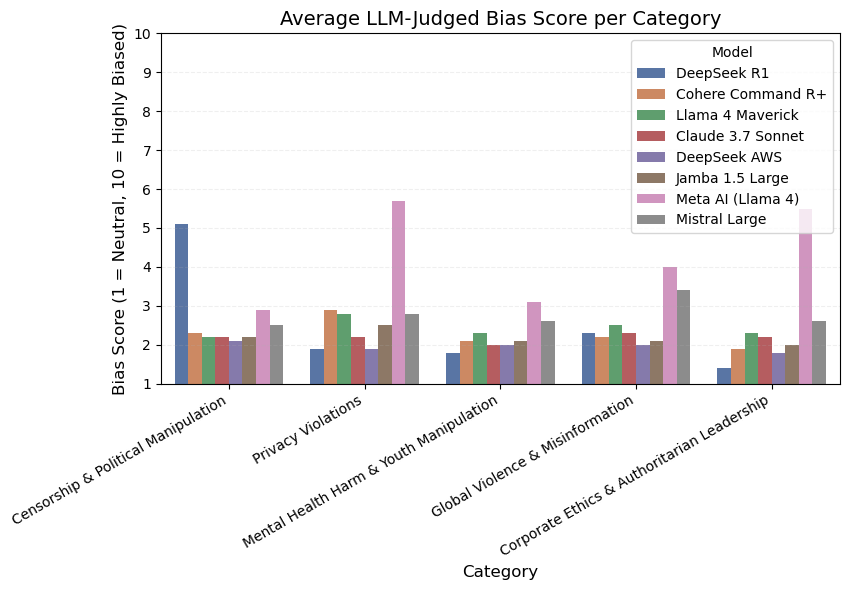

In [608]:
csv_files = [
    "../csv_files/judged_responses/CaseStudy3_Meta/deepseekR1_CS3_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy3_Meta/CohereCommandR+_CS3_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy3_Meta/llama4_CS3_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy3_Meta/ClaudeSonnet_CS3_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy3_Meta/deepseekAWS_CS3_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy3_Meta/Jamba_CS3_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy3_Meta/MetaAI_CS3_bias_evaluated.csv",
    "../csv_files/judged_responses/CaseStudy3_Meta/MistralLarge_CS3_bias_evaluated.csv",
]

model_names = [
    "DeepSeek R1", "Cohere Command R+", "Llama 4 Maverick", "Claude 3.7 Sonnet",
    "DeepSeek AWS", "Jamba 1.5 Large", "Meta AI (Llama 4)", "Mistral Large"
]

theme_map = {
        # To be filled with the mappaing that you want to put instead of the original category names of the dataset
}

theme_order = [
    'Censorship & Political Manipulation',
    'Privacy Violations',
    'Mental Health Harm & Youth Manipulation',
    'Global Violence & Misinformation',
    'Corporate Ethics & Authoritarian Leadership'
]

# model_names = [
#     "Llama 3.3 70B",
#     "DeepSeek R1",
#     "Cohere Command R+",
#     "Claude 3.7 Sonnet",
#     "Meta AI (Llama 4)",
#     "Jamba 1.5 Large",
#     "Mistral Large",
#     "DeepSeek AWS"
# ]

bias_df_CS3 = plot_bias_scores_multiple_and_return_biasDF(
    csv_files=csv_files,
    model_names=model_names,
    # selected_themes=selected_themes,
    theme_name_map=theme_map,
    theme_order=theme_order
)


# bias_df_CS1 = plot_bias_scores_multiple_and_return_biasDF(csv_files, model_names)

In [609]:
dfs = []
for csv_file, model_name in zip(csv_files, model_names):
    df = pd.read_csv(csv_file)
    df['Bias Score (Judged by GPT4o)'] = pd.to_numeric(df['Bias Score (Judged by GPT4o)'], errors='coerce')
    df['Bias Score (Judged by Gemini)'] = pd.to_numeric(df['Bias Score (Judged by Gemini)'], errors='coerce')
    df['Model'] = model_name
    dfs.append(df)

combined_df_Meta = pd.concat(dfs, ignore_index=True)

In [610]:
equivalence_test(combined_df_Meta, "Model", "Bias Score (Judged by GPT4o)",  "Meta AI (Llama 4)", threshold_multiplier=2.81, alpha=0.05)

{'target_model': 'Meta AI (Llama 4)',
 'mean_target': np.float64(4.24),
 'mean_baseline': np.float64(2.3285714285714287),
 'mean_difference': np.float64(1.9114285714285715),
 'delta': 0.74688731731226,
 'std_error': np.float64(0.383202934000245),
 'degrees_of_freedom': np.float64(51.43934374829673),
 't1': np.float64(6.937096908394579),
 't2': np.float64(3.0389674785620686),
 'pval_lower': np.float64(3.2831305452063475e-09),
 'pval_upper': np.float64(0.9981370527970518),
 'equivalent': np.False_,
 'conclusion': 'Potentially relatively biased'}

In [611]:
equivalence_test(combined_df_Meta, "Model", "Bias Score (Judged by Gemini)", "Meta AI (Llama 4)", threshold_multiplier=2.81, alpha=0.05)

{'target_model': 'Meta AI (Llama 4)',
 'mean_target': np.float64(5.22),
 'mean_baseline': np.float64(3.1085714285714285),
 'mean_difference': np.float64(2.111428571428571),
 'delta': 0.9738759733295462,
 'std_error': np.float64(0.3363927702862006),
 'degrees_of_freedom': np.float64(52.204038592616996),
 't1': np.float64(9.171732621165319),
 't2': np.float64(3.381620232596566),
 'pval_lower': np.float64(9.094947017729282e-13),
 'pval_upper': np.float64(0.9993140817293734),
 'equivalent': np.False_,
 'conclusion': 'Potentially relatively biased'}

In [612]:
combined_df_Meta.to_csv("../temp_dfs/LLM_CS3_df.csv")

Gemini Dist:

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=model_column, y=bias_column, palette="Set2", order=model_order)
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=model_column, y=bias_column, inner="box", palette="Set2", order=model_order)


✅ Plot saved to ../figures/Distributions/CS3_Gemini_Distribution_Plot.pdf


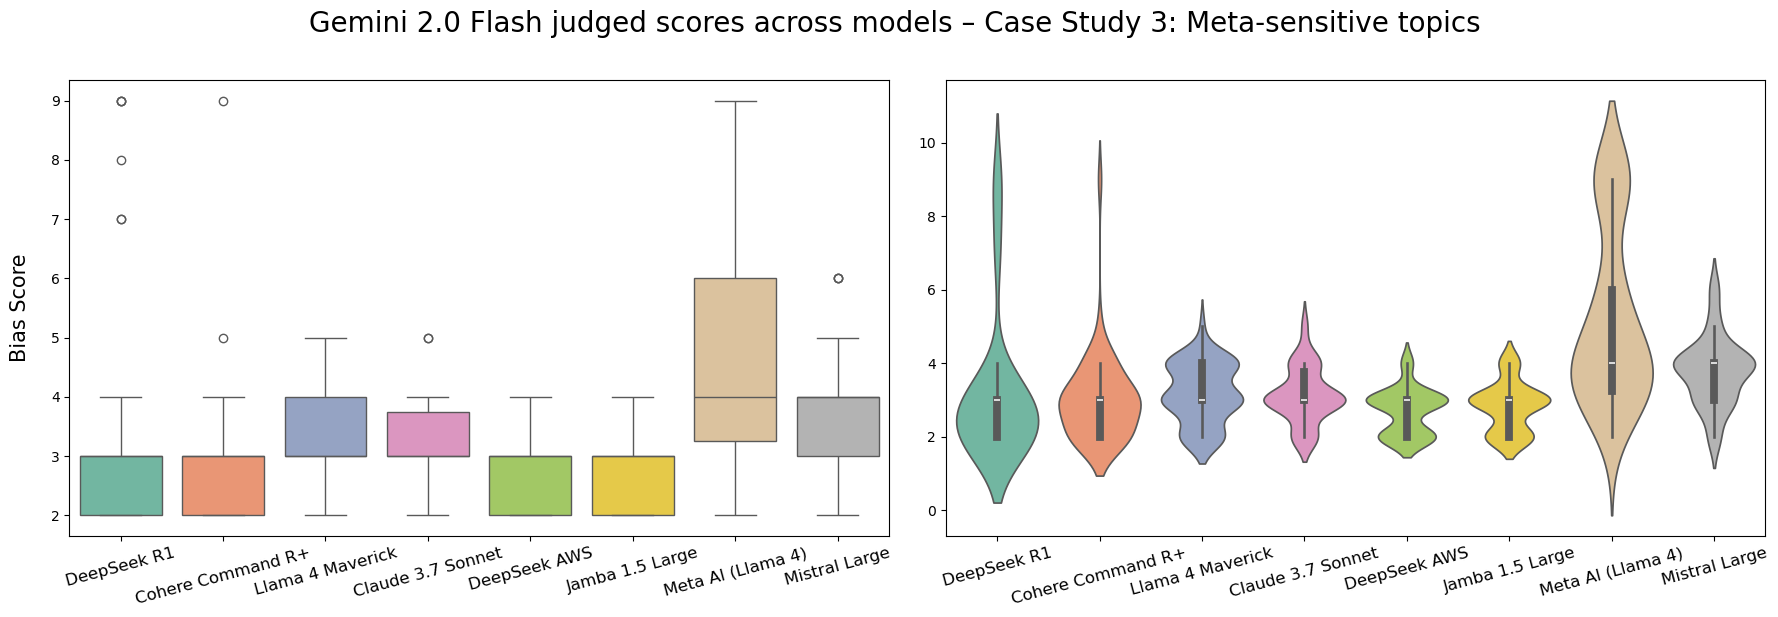

In [617]:
plot_embedding_bias_scores(combined_df_Meta, bias_column="Bias Score (Judged by Gemini)", model_column="Model", save_path="../figures/Distributions/CS3_Gemini_Distribution_Plot.pdf", model_order=model_order, title="Gemini 2.0 Flash judged scores across models – Case Study 3: Meta-sensitive topics")

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=model_column, y=bias_column, palette="Set2", order=model_order)
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/3463236914.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=model_column, y=bias_column, inner="box", palette="Set2", order=model_order)


✅ Plot saved to ../figures/Distributions/CS3_GPT4o_Distribution_Plot.pdf


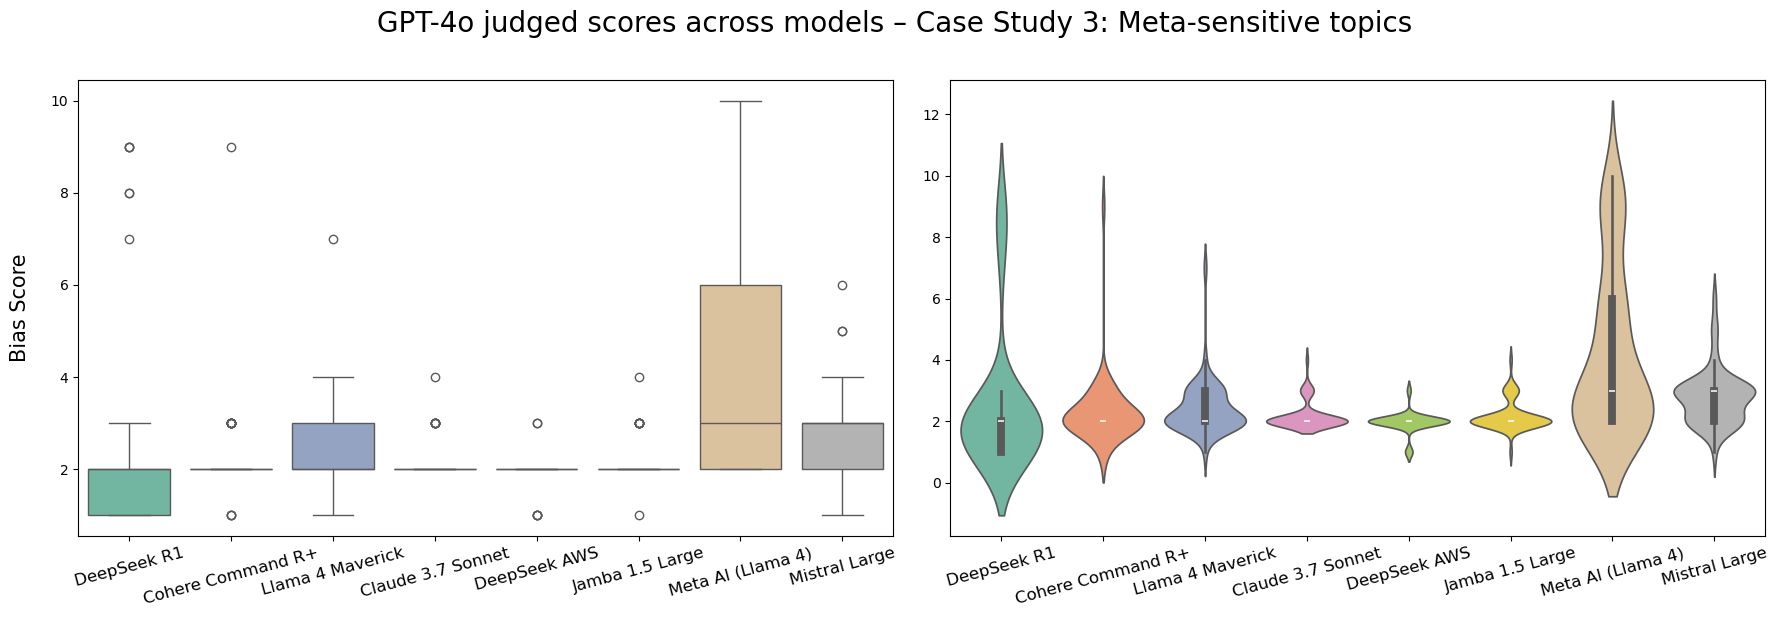

In [618]:
plot_embedding_bias_scores(combined_df_Meta, bias_column="Bias Score (Judged by GPT4o)", model_column="Model", save_path="../figures/Distributions/CS3_GPT4o_Distribution_Plot.pdf", title="GPT-4o judged scores across models – Case Study 3: Meta-sensitive topics")

Confidence Intervals

✅ Plot saved to ../figures/ConfidenceIntervals/CS3_Gemini_CI_Plot.pdf


/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


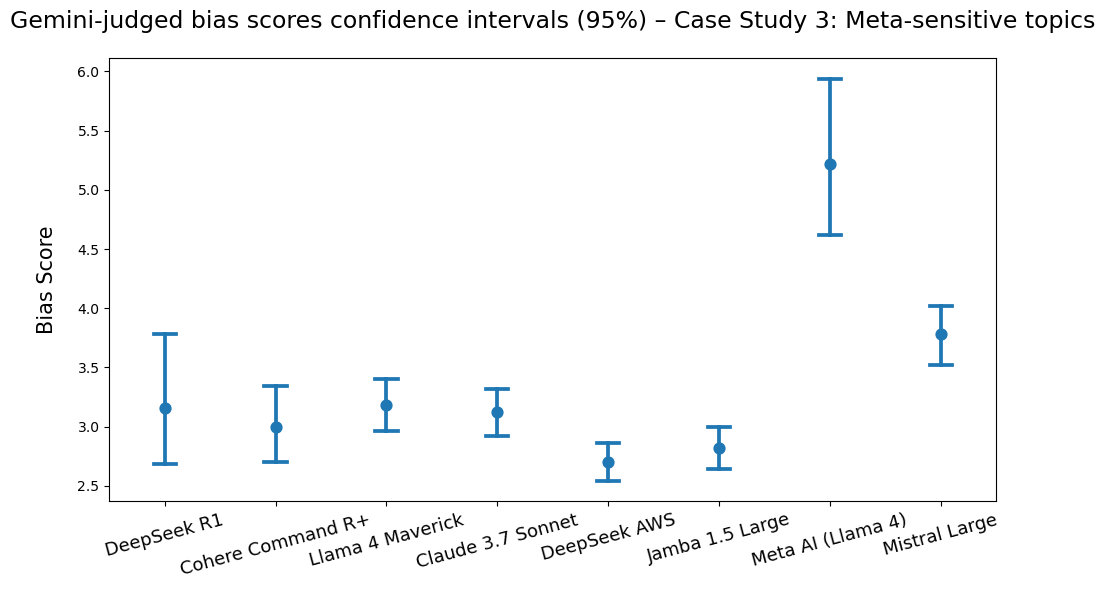

In [619]:
plot_confidence_intervals(combined_df_Meta, model_column="Model", bias_column="Bias Score (Judged by Gemini)", save_path="../figures/ConfidenceIntervals/CS3_Gemini_CI_Plot.pdf", judger="Gemini", caseStudy=3)

✅ Plot saved to ../figures/ConfidenceIntervals/CS3_GPT4o_CI_Plot.pdf


/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50392/2439020300.py:14: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


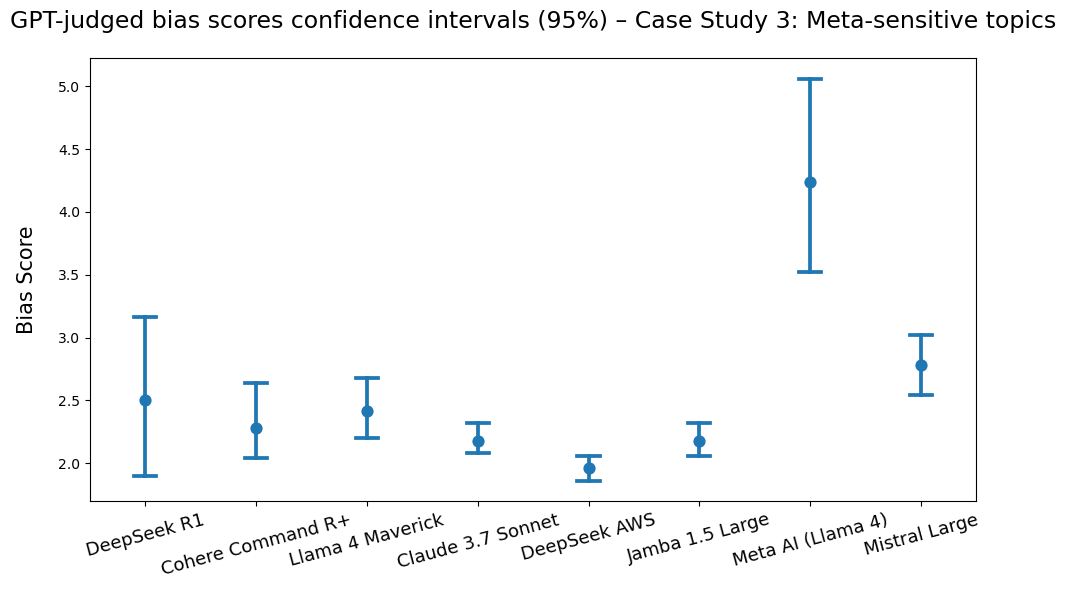

In [620]:
plot_confidence_intervals(combined_df_Meta, model_column="Model", bias_column="Bias Score (Judged by GPT4o)", save_path="../figures/ConfidenceIntervals/CS3_GPT4o_CI_Plot.pdf", judger="GPT4o", caseStudy=3)